In [1]:
# !pip install -q git+https://github.com/THU-MIG/yolov10.git

In [2]:
# from ultralytics import YOLOv10
# YOLO_model = YOLOv10("/kaggle/input/ckpckp/yolov10_detect_big.pt")

In [3]:
!pip install -q transformers evaluate jiwer 

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms
import os
import subprocess
from IPython.display import FileLink, display
import random
import matplotlib.pyplot as plt
from evaluate import load
from transformers import AdamW, TrOCRProcessor, VisionEncoderDecoderModel, VisionEncoderDecoderConfig, Seq2SeqTrainer, Seq2SeqTrainingArguments, EarlyStoppingCallback, default_data_collator
from tqdm.notebook import tqdm
import warnings
import wandb
import time
from sklearn.model_selection import train_test_split
import pandas as pd

warnings.filterwarnings("ignore")
os.environ["TOKENIZERS_PARALLELISM"] = 'false'
wandb.login(key="4a5d274772a4974f7135c3fcdf92080c71668384")

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [5]:
crop_df = pd.read_csv('/kaggle/input/vietnamese-license-plate-ocr/labels/crop_labels.csv')
def add_crop_path(filename):
    return f'cropped/{filename}'
crop_df['Name'] = crop_df['Name'].apply(add_crop_path)
crop_train_df, crop_temp_df = train_test_split(crop_df, test_size=0.2, stratify=crop_df['Type'], random_state=42)
crop_valid_df, crop_test_df = train_test_split(crop_temp_df, test_size=0.5, stratify=crop_temp_df['Type'], random_state=42)
print(crop_df.head())
print(len(crop_df))

                Name      Label  Type
0  cropped/car_1.jpg  30F 11292     0
1  cropped/car_2.jpg  30F 78286     0
2  cropped/car_3.jpg  30F 90230     0
3  cropped/car_4.jpg  30E 49536     0
4  cropped/car_5.jpg  98A 29814     0
6643


In [6]:
gen_df = pd.read_csv('/kaggle/input/vietnamese-license-plate-ocr/labels/gen_labels.csv')
def add_gen_path(filename):
    return f'generated/{filename}'
gen_df['Name'] = gen_df['Name'].apply(add_gen_path)
gen_df = gen_df.groupby('Type', group_keys=False).apply(lambda x: x.sample(frac=0.25, random_state=42))
gen_train_df, gen_temp_df = train_test_split(gen_df, test_size=0.2, stratify=gen_df['Type'], random_state=42)
gen_valid_df, gen_test_df = train_test_split(gen_temp_df, test_size=0.5, stratify=gen_temp_df['Type'], random_state=42)
print(gen_df.head())
print(len(gen_df))

                            Name        Label  Type
2403  generated/type3_403_lp.jpg    52LD 5264     0
2865  generated/type3_865_lp.jpg   79LD 00256     0
2159  generated/type3_159_lp.jpg   37HC 00312     0
507   generated/type1_507_lp.jpg    29A 70408     0
2462  generated/type3_462_lp.jpg  29MĐ3 22299     0
1387


In [7]:
train_df = pd.concat([crop_train_df, gen_train_df], ignore_index=True)
valid_df = pd.concat([crop_valid_df, gen_valid_df], ignore_index=True)
test_df = pd.concat([crop_test_df, gen_test_df], ignore_index=True)

In [8]:
print(f"Number of training examples: {len(train_df)}")
print(f"Number of validation examples: {len(valid_df)}")
print(f"Number of testing examples: {len(test_df)}")

Number of training examples: 6423
Number of validation examples: 803
Number of testing examples: 804


In [9]:
def apply_augmentations(image):
    """Apply augmentations to the given image."""
    augmentation_pipeline = transforms.Compose([
        transforms.RandomRotation(degrees=(-5, 5)),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
        transforms.GaussianBlur(kernel_size=3),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=5),
    ])
    
    return augmentation_pipeline(image)

In [10]:
class LPDataset(Dataset):
    def __init__(self, data_frame, processor, max_target_length=10, augment=False):
        self.df = data_frame
        self.processor = processor
        self.max_target_length = max_target_length
        self.augmentation = augment
            
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get file name + text 
        img_file = self.df.iloc[idx, 0]
        text = self.df.iloc[idx, 1]
        #img_index = get_index(img_file)
        img_dir = "/kaggle/input/vietnamese-license-plate-ocr"
        img_path = os.path.join(img_dir, img_file)
        
        # prepare image (i.e. resize + normalize)
        image = Image.open(img_path).convert("RGB")
        if self.augmentation:
            image = apply_augmentations(image)
        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        
        # add labels (input_ids) by encoding the text
        labels = self.processor.tokenizer(text, 
                                          padding="max_length", 
                                          max_length=self.max_target_length).input_ids
        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

In [11]:
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
train_dataset = LPDataset(data_frame=train_df, processor=processor, augment=True)
valid_dataset = LPDataset(data_frame=valid_df, processor=processor)
test_dataset = LPDataset(data_frame=test_df, processor=processor)

preprocessor_config.json:   0%|          | 0.00/224 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

In [12]:
encoding = train_dataset[0]
for k,v in encoding.items():
  print(k, v.shape)

pixel_values torch.Size([3, 384, 384])
labels torch.Size([10])


In [13]:
data_dir = "/kaggle/input/vietnamese-license-plate-ocr"
image = Image.open(os.path.join(data_dir, train_df.iloc[0,0])).convert("RGB")
image

In [14]:
labels = encoding['labels']
labels[labels == -100] = processor.tokenizer.pad_token_id
label_str = processor.decode(labels, skip_special_tokens=True)
print(label_str)

29A 04501


In [15]:
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=16)
test_dataloader = DataLoader(test_dataset, batch_size=16)

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_config = VisionEncoderDecoderConfig.from_pretrained("/kaggle/input/kms-ckpt/checkpoint-9720")
model = VisionEncoderDecoderModel.from_pretrained("/kaggle/input/kms-ckpt/checkpoint-9720", config= model_config)
model.to(device)

VisionEncoderDecoderModel has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.


VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=False)
              (key): Linear(in_features=768, out_features=768, bias=False)
              (value): Linear(in_features=768, out_features=768, bias=False)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fea

In [17]:
import shutil

# Define the source and destination paths
src_checkpoint = "/kaggle/input/kms-ckpt/checkpoint-9720"
dst_checkpoint = "/kaggle/working/LP-OCR-model/checkpoint-9720"

# Copy the checkpoint to the writable directory
shutil.copytree(src_checkpoint, dst_checkpoint)

'/kaggle/working/LP-OCR-model/checkpoint-9720'

In [18]:
# # set special tokens used for creating the decoder_input_ids from the labels
# model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
# model.config.pad_token_id = processor.tokenizer.pad_token_id

# # make sure vocab size is set correctly
# model.config.vocab_size = model.config.decoder.vocab_size

# # set beam search parameters
# model.config.eos_token_id = processor.tokenizer.sep_token_id
# model.config.max_length = 10
# model.config.length_penalty = 0
# model.config.early_stopping = True
# model.config.num_beams = 2

In [19]:
training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="steps", 
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    fp16=True, 
    output_dir="/kaggle/working/LP-OCR-model",
    logging_steps=5,
    save_steps=30,
    eval_steps=30,
    num_train_epochs=69,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False
)

In [20]:
cer_metric = load("cer")

def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(labels_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return {"cer": cer}

In [21]:
# instantiate trainer
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=processor.feature_extractor,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    data_collator=default_data_collator,
)
trainer.train(resume_from_checkpoint=True)

There were missing keys in the checkpoint model loaded: ['decoder.output_projection.weight'].
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Currently logged in as: namnguyen2103. Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.18.3
wandb: Run data is saved locally in /kaggle/working/wandb/run-20241116_041210-7g11j8fs
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run /kaggle/working/LP-OCR-model
wandb: ⭐️ View project at https://wandb.ai/namnguyen2103/huggingface
wandb: 🚀 View run at https://wandb.ai/namnguyen2103/huggingface/runs/7g11j8fs


Step,Training Loss,Validation Loss,Cer
9750,0.007800,0.315258,0.046743
9780,0.009700,0.311100,0.046198
9810,0.005100,0.313722,0.044154
9840,0.009200,0.314761,0.046198
9870,0.021600,0.315714,0.044290
9900,0.014300,0.319210,0.045789
9930,0.006800,0.320903,0.046607
9960,0.014600,0.314610,0.045516
9990,0.014000,0.317610,0.045244
10020,0.010400,0.319048,0.047833


Could not locate the best model at /kaggle/working/LP-OCR-model/checkpoint-1680/pytorch_model.bin, if you are running a distributed training on multiple nodes, you should activate `--save_on_each_node`.


TrainOutput(global_step=13869, training_loss=0.0022003122418442333, metrics={'train_runtime': 34955.4303, 'train_samples_per_second': 12.679, 'train_steps_per_second': 0.397, 'total_flos': 3.316302689419301e+20, 'train_loss': 0.0022003122418442333, 'epoch': 69.0})

In [22]:
model.save_pretrained("LP-OCR-model/best")

In [23]:
def download_file(path, download_file_name):
    os.chdir('/kaggle/working/')
    zip_name = f"/kaggle/working/{download_file_name}.zip"
    command = f"zip {zip_name} {path} -r"
    result = subprocess.run(command, shell=True, capture_output=True, text=True)
    if result.returncode != 0:
        print("Unable to run zip command!")
        print(result.stderr)
        return
    display(FileLink(f'{download_file_name}.zip'))

In [24]:
download_file('/kaggle/working/LP-OCR-model/best', 'ckp')

/kaggle/working/ckp.zip

In [25]:
# optimizer = AdamW(model.parameters(), lr=5e-5)
# num_epochs = 150
# best_valid_loss = float('inf')
# wandb.login(key="4a5d274772a4974f7135c3fcdf92080c71668384")
# wandb.init(project='LP-OCR',
#                    resume='allow',
#                    config={'num_epochs': num_epochs})
# wandb.watch(model)

In [26]:
# for epoch in range(num_epochs):
#     # ------------------- TRAIN -------------------
#     start = time.time()
#     model.train()
#     train_loss = 0.0

#     for batch in tqdm(train_dataloader, desc=f'Epoch {epoch+1}/{num_epochs}'):
#         # get the inputs and move to device
#         for k, v in batch.items():
#             batch[k] = v.to(device)

#         # forward + backward + optimize
#         outputs = model(**batch)
#         loss = outputs.loss
#         loss.backward()
#         optimizer.step()
#         optimizer.zero_grad()

#         train_loss += loss.item()

#     end = time.time()
#     train_loss /= len(train_dataloader)
    
#     # ------------------- VALID -------------------
#     model.eval()
#     valid_loss = 0.0
#     with torch.no_grad():
#         for batch in tqdm(valid_dataloader):
#             # run batch generation
#             outputs = model.generate(batch["pixel_values"].to(device))
#             # compute metrics
#             cer = compute_cer(pred_ids=outputs, label_ids=batch["labels"])
#             valid_loss += cer

#     valid_loss /= len(valid_dataloader)
    
#     # ------------------- LOG -------------------
#     wandb.log({
#         'train_loss': train_loss,
#         'valid_loss': valid_loss,
#         'learning_rate': optimizer.param_groups[0]['lr']
#     })
    
#     # ------------------- VERBOSE -------------------
#     print(f'Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Validation CER: {valid_loss:.4f} | Time: {end-start:.2f}s')

#     # ------------------- CHECKPOINT -------------------
#     model.save_pretrained("LP-OCR-model/latest")
#     if valid_loss < best_valid_loss:
#         best_valid_loss = valid_loss
#         model.save_pretrained("LP-OCR-model/best")
#         print("New best checkpoint saved!")
        
# wandb.finish()

In [27]:
# loading model and config from pretrained folder
# encoder_decoder_config = VisionEncoderDecoderConfig.from_pretrained("/kaggle/input/ksajhdlksajdklsajdkljaskdl/LP-OCR-model/best")
# LP_OCR_model = VisionEncoderDecoderModel.from_pretrained("/kaggle/input/ksajhdlksajdklsajdkljaskdl/LP-OCR-model/best", config=encoder_decoder_config).to(device)
# encoder_decoder_config = VisionEncoderDecoderConfig.from_pretrained("/kaggle/working/LP-OCR-model/best")
# LP_OCR_model = VisionEncoderDecoderModel.from_pretrained("/kaggle/working/LP-OCR-model/best", config=encoder_decoder_config).to(device)
LP_OCR_model = model

In [28]:
generated_text = []
with torch.no_grad():
    for batch in tqdm(DataLoader(train_dataset, batch_size=16)):
        # run batch generation
        outputs = LP_OCR_model.generate(batch["pixel_values"].to(device))
        generated_text_batch = processor.batch_decode(outputs, skip_special_tokens=True)
        generated_text.extend(generated_text_batch) 

  0%|          | 0/402 [00:00<?, ?it/s]

In [29]:
ground_truths = train_df.iloc[:, 1].tolist()

correct = 0
for generated, ground_truth in zip(generated_text, ground_truths):
    if generated == ground_truth:
        correct += 1

accuracy = correct / len(ground_truths) * 100
print(f"Train accuracy: {accuracy:.2f}%")

Train accuracy: 99.49%


In [30]:
generated_text = []
with torch.no_grad():
    for batch in tqdm(DataLoader(test_dataset, batch_size=16)):
        # run batch generation
        outputs = LP_OCR_model.generate(batch["pixel_values"].to(device))
        generated_text_batch = processor.batch_decode(outputs, skip_special_tokens=True)
        generated_text.extend(generated_text_batch) 

  0%|          | 0/51 [00:00<?, ?it/s]

In [31]:
ground_truths = test_df.iloc[:, 1].tolist()
filenames = test_df.iloc[:, 0].tolist() 

correct = 0
incorrect_files = [] 

for filename, generated, ground_truth in zip(filenames, generated_text, ground_truths):
    if generated == ground_truth:
        correct += 1
    else:
        incorrect_files.append((filename, generated, ground_truth)) 

accuracy = correct / len(ground_truths) * 100
print(f"Test accuracy: {accuracy:.2f}%")

Test accuracy: 80.97%


In [32]:
incorrect_files

[('cropped/type2_148.jpg', '79LD 00576', '33 315FM'),
 ('cropped/type4_415.jpg', '80A 06033', '80A 06023'),
 ('cropped/type7_311.jpg', '29B 19528', '29B 19526'),
 ('cropped/type7_100.jpg', '30F 65533', '30F 09503'),
 ('cropped/type3_124.jpg', '50LD 02853', '50TĐ 03027'),
 ('cropped/type7_845.jpg', '50H 34949', '50H 34549'),
 ('cropped/type3_373.jpg', '60LD 01 428', '60LD 01428'),
 ('cropped/type3_871.jpg', '79LD 00014', '79LD 00044'),
 ('cropped/type7_840.jpg', '60E 00255', '69E 00250'),
 ('cropped/type7_855.jpg', '50H 40928', '50H 40978'),
 ('cropped/type3_609.jpg', '68A 09532', '68HC 00031'),
 ('cropped/type7_179.jpg', '26B 00450', '26B 00487'),
 ('cropped/type5_447.jpg', 'VT 2285', 'HB 2285'),
 ('cropped/type7_372.jpg', '29H 38122', '29H 78122'),
 ('cropped/type2_775.jpg', '29 78280', '29 782RL'),
 ('cropped/type4_432.jpg', '50A 02076', '50A 02078'),
 ('cropped/type5_397.jpg', 'TT 4114', 'TT 4116'),
 ('cropped/type7_045.jpg', '29H 01030', '29F 01030'),
 ('cropped/type3_401.jpg', '29

In [33]:
def get_label_from_name(df, image_file_name):
    # Check if the image file exists in the DataFrame
    label_row = df[df['Name'] == image_file_name]
    
    if not label_row.empty:
        return label_row['Label'].values[0]
    else:
        return None

def random_infer():
    # Get a random image path from the test folder
    data_dir = "/kaggle/input/vietnamese-license-plate-ocr/generated"
    image_files = os.listdir(data_dir)
    random_image_file = random.choice(image_files)
#     label = get_label_from_name(df, random_image_file)
#     print("Label: " + label)
    
    image_path = os.path.join(data_dir, random_image_file)
    image = Image.open(image_path).convert("RGB")
    plt.imshow(image)
    pixel_values = processor(image, return_tensors="pt").pixel_values.to(device)

    # Generate text from the image using OCR
    generated_ids = LP_OCR_model.generate(pixel_values)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    print(f"Generated text: {generated_text}")

    return generated_text

    # Process the image
    # yolo_results = YOLO_model(image) 
    # if len(yolo_results) > 0:        
    #     bbox = yolo_results[0].boxes.xyxy[0]  
    #     xmin, ymin, xmax, ymax = map(int, bbox)
    #     cropped_image = image.crop((xmin, ymin, xmax, ymax))

    #     # Process the cropped image with OCR
    #     pixel_values = processor(cropped_image, return_tensors="pt").pixel_values.to(device)

    #     # Generate text from the image using OCR
    #     generated_ids = LP_OCR_model.generate(pixel_values)
    #     generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    #     print(f"Generated text: {generated_text}")

    #     return generated_text
    # else:
    #     print("No license plate detected")
    #     return None

Generated text: 50H 50046


'50H 50046'

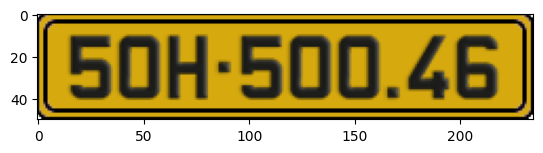

In [34]:
random_infer()